<a href="https://colab.research.google.com/github/minh071289/MachineLearning/blob/main/uet_ml_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernel SVM
Your task is to implement linear SVM, kernel SVM, and soft margin SVM from scratch. You can use the libraries imported in the cell below. You are **NOT** allowed to use other libraries.

In [5]:
!pip install "qpsolvers[open_source_solvers]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.5/594.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.5/166.5 kB 12.3 MB/s eta 0:00:00


In [6]:
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import qpsolvers

In [7]:
torch.manual_seed(0)
def gen_data(
    mu_pos = torch.FloatTensor([2.5, 2.5]),
    mu_neg = torch.FloatTensor([-2.5, -2.5]),
    Sigma_pos = torch.FloatTensor([[2, 0.3], [0.5, 1]]),
    Sigma_neg = torch.FloatTensor([[2, 0.3], [0.5, 1]]),
    n = 100
  ):
  class_pos = torch.randn(size=(n, 2)) @ Sigma_pos + mu_pos
  class_neg = torch.randn(size=(n, 2)) @ Sigma_neg + mu_neg
  return class_pos, class_neg

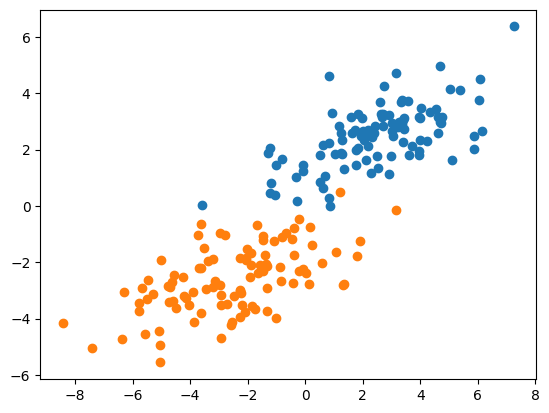

In [8]:
class_pos, class_neg = gen_data()
label_pos, label_neg = torch.ones(class_pos.shape[0], 1), 0 - torch.ones(class_neg.shape[0], 1)
train_label = torch.cat([label_pos, label_neg], dim=0)
train_input = torch.cat([class_pos, class_neg], dim=0)
train_data = torch.cat([train_input, train_label], dim=1)

plt.scatter(train_data[train_data[:, 2] == 1, 0], train_data[train_data[:, 2] == 1, 1])
plt.scatter(class_neg[:, 0], class_neg[:, 1])
plt.show()

In [9]:
class SVM:
  def __init__(self, kernel, C):
    """
    @param kernel: kernel function, could be 'linear', 'poly', 'rbf', or your own.
    Note that rbf kernel is also called Gaussian kernel.
    @param C: regularization parameter for soft-margin SVM, see lecture slide
    """
    self.kernel = kernel
    self.C = C
    self.support_vectors = []
    # Your code here
    self.alpha = None
    self.bias = 0.0
    self.support_labels = None

    if kernel == 'linear':
        self.kernel_func = lambda x, y: torch.matmul(x, y.T)
    elif kernel == 'rbf':
        self.kernel_func = lambda x, y: torch.exp(-torch.cdist(x, y)**2 / 2)
    else:
        raise NotImplementedError("Only 'linear' and 'rbf' kernels are implemented.")

  def train(self, train_data):
    """
    train_data: a list of (x, y) pairs, where x is a data point and y is a label
    """
    # Your code here
    # you should store the support vectors in self.support_vectors
    X = train_data[:, :2]
    y = train_data[:, 2].view(-1, 1)

    n = X.shape[0]
    K = self.kernel_func(X, X)

    P = (y @ y.T) * K
    q = -torch.ones(n, 1)

    G = torch.cat([torch.eye(n), -torch.eye(n)], dim=0)
    h = torch.cat([self.C * torch.ones(n, 1), torch.zeros(n, 1)], dim=0)

    A = y.T
    b = torch.zeros(1)

    sol = qpsolvers.solve_qp(
        P.numpy(), q.numpy().flatten(), G.numpy(), h.numpy().flatten(), A.numpy(), b.numpy(), solver="osqp"
    )
    alpha = torch.tensor(sol).view(-1, 1).float()

    sv = (alpha > 1e-5).view(-1)
    self.alpha = alpha[sv]
    self.support_vectors = X[sv]
    self.support_labels = y[sv]

  def infer(self, data):
    """
    data: a list of data points
    return: a list of predictions
    """
    # Your code here
    data = data.float()
    sv = self.support_vectors.float()
    K = self.kernel_func(data, sv)
    pred = (K @ (self.alpha * self.support_labels)).view(-1)
    return torch.sign(pred)

/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'P' of your problem to scipy.sparse.csc_matrix to pass it to solver 'osqp'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'G' of your problem to scipy.sparse.csc_matrix to pass it to solver 'osqp'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:28: SparseConversionWarning: Converted matrix 'A' of your problem to scipy.sparse.csc_matrix to pass it to solver 'osqp'; for best performance, build your matrix as a csc_matrix directly.
  warnings.warn(


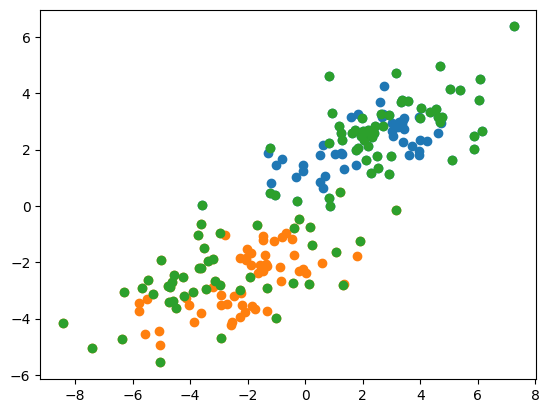

In [10]:
# svm = SVM(kernel='linear', C=np.inf) # linear, hard margin SVM
svm = SVM(kernel='rbf', C=1) # rbf, soft margin SVM
svm.train(train_data)

# visualize
plt.scatter(train_data[train_data[:, 2] == 1, 0], train_data[train_data[:, 2] == 1, 1])
plt.scatter(train_data[train_data[:, 2] == -1, 0], train_data[train_data[:, 2] == -1, 1])
plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1])
plt.show()

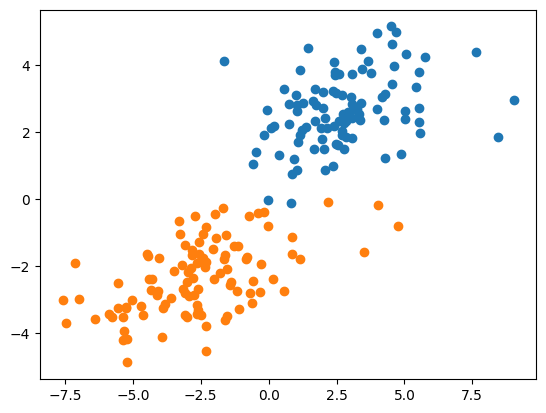

In [11]:
test_pos, test_neg = gen_data(n=100)
data = torch.cat([test_pos, test_neg])

labels = svm.infer(data)

# visualize
plt.scatter(data[labels == 1, 0], data[labels == 1, 1])
plt.scatter(data[labels == -1, 0], data[labels == -1, 1])
plt.show()